Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 2: Set Covering with Evolutionary Algorithms

Second lab + peer review. List this activity in your final report, it will be part of your exam.

## Task

Given a number $N$ and some lists of integers $P = (L_0, L_1, L_2, ..., L_n)$, 
determine, if possible, $S = (L_{s_0}, L_{s_1}, L_{s_2}, ..., L_{s_n})$
such that each number between $0$ and $N-1$ appears in at least one list

$$\forall n \in [0, N-1] \ \exists i : n \in L_{s_i}$$

and that the total numbers of elements in all $L_{s_i}$ is minimum. 

## Instructions

* Create the directory `lab1` inside the course repo (the one you registered with Andrea)
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)
* Use `problem` to generate the problems with different $N$
* In the `README.md`, report the the total numbers of elements in $L_{s_i}$ for problem with $N \in [5, 10, 20, 100, 500, 1000]$ and the total number on $nodes$ visited during the search. Use `seed=42`.
* Use `GitHub Issues` to peer review others' lab

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.

**Deadline**

* Sunday, October 16th 23:59:59 for the working solution
* Sunday, October 23rd 23:59:59 for the peer reviews

In [1]:
import random
import logging
import numpy as np

from collections import namedtuple
from matplotlib import pyplot as plt

### Problem representation:
We need the least amount of numers (given *n* lists *S*), that cover all the numbers $[0, N-1]$:

\begin{equation}
min \sum \limits _{j=1} ^{n} c_{j}x_{j}
\end{equation}

where $c_{j}$ is the cost of the given list and 

\begin{equation}
x_{j} \ for \ list \ S_{j} \ = 
  \begin{cases}
    1 & \text{if $S_{j}$ selected}\\
    0 & \text{if not}\\
  \end{cases} 
\end{equation}

The cost of adding a list to the solution is the number of elements in the list. As priority of node expansion we use the length of the list itself. 

#### Constraints
Given the problem code, we can see that:
* Lists are of length $[N//5, N//2]$
* The number of lists to explore is between $[N, N*5]$

**Linear programming problem contraints:**
* Every element in the solution space must be covered. *This constraint cannot be guaranteed.*
* Values for $x_{j} \in \{0, 1\}$ 
**NP-hard optimization problem.** 

In [2]:
def problem(N, seed=None):
    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

 ##### **ONE-MAX**: Proposed Solution


In [144]:
POPULATION_SIZE = 100
OFFSPRING_SIZE = 500

NUM_GENERATIONS = 50

In [142]:
Individual = namedtuple("Individual", ["genome", "fitness"])

# Returns the fitness of given genome
def set_covering(genome, problem_lists):
    genome_lists = problem_lists[list(genome)]
    cov = set(elem for l in genome_lists for elem in l)
    # fitness is given by the amount of elements coverend by the genome
    # and by the negative of the amount of elements in the genome
    return len(cov), -sum(len(l) for l in genome_lists)


def tournament(population, tournament_size=2):
    return max(random.choices(population, k=tournament_size), key=lambda i: i.fitness)


def cross_over(genome1, genome2, problem_size):
    cut = random.randint(0, problem_size)
    return genome1[:cut] + genome2[cut:]


def mutation(genome, problem_size):
    point = random.randint(0, problem_size - 1)
    return genome[:point] + (1 - genome[point],) + genome[point + 1 :]

#### *Genetic Algorithm*

In [5]:
logging.getLogger().setLevel(logging.INFO)

Initial Population

In [7]:
def get_population(problem_size, problem_lists):
    population = list()

    # Get POPULATION_SIZE=10 genomes (lists of lists, ramdomly chosen from problem lists)
    for genome in [tuple([random.choice([True, False]) for _ in range(problem_size)]) for _ in range(POPULATION_SIZE)]:
        population.append(Individual(genome, set_covering(genome, problem_lists)))

    logging.info(f"init: pop_size={len(population)}; max={max(population, key=lambda i: i.fitness)[1]}")
    return population

Evolution

In [134]:
def evolution_steady_state(N): 
    problem_lists = np.array(list(set(tuple(i) for i in problem(N, seed=42))), dtype=list)
    problem_size = len(problem_lists)
    population = get_population(problem_size, problem_lists)

    max_generations = N * NUM_GENERATIONS

    # Keep track of all individuals of each generation
    fitness_log = [(0, i.fitness) for i in population]

    # Steady state GA
    actual_generations = 0
    while actual_generations < NUM_GENERATIONS:
        offspring = list()
        # Generate offspring...
        for i in range(OFFSPRING_SIZE):
            # Explore
            if actual_generations/NUM_GENERATIONS < 0.8:
                # ...by mutation
                if random.random() < 0.3:
                    p = tournament(population)
                    o = mutation(p.genome, problem_size)
                    
                # ...by cross-over
                else:
                    p1 = tournament(population, N//4)
                    p2 = tournament(population, N//4)
                    o = cross_over(p1.genome, p2.genome, problem_size)
            # Exploit
            else:
                # ...by mutation
                if random.random() < 0.8:
                    p = tournament(population, N)
                    o = mutation(p.genome, problem_size)
                    
                # ...by cross-over
                else:
                    p1 = tournament(population, N)
                    p2 = tournament(population, N)
                    o = cross_over(p1.genome, p2.genome, problem_size)
            f = set_covering(o, problem_lists)
            fitness_log.append((actual_generations+1, f))
            offspring.append(Individual(o, f))
        population += offspring
    ### *****Before selecting population, remove "duplicates"
        population = sorted(population, key=lambda i: i.fitness, reverse=True)[:POPULATION_SIZE]
        actual_generations += 1
        # Found optimum
        if population[0].fitness[0] + population[0].fitness[1] == 0:
            print([-max(f[1][0] + f[1][1] for f in fitness_log if f[0] == x) / (x + 1) for x in range(actual_generations)])
            break

    # Population best
    best = problem_lists[list(population[0].genome)]
    logging.debug(
        f"For problem N={N}: fittest individual final population: {best},\
            \nis {set(elem for l in best for elem in l) == set(range(N))} valid solution with fitness {population[0].fitness}.\n"
        ) 
    logging.info(f"Best indivudual with fitness = {population[0].fitness}")
    return fitness_log, actual_generations

Performance Evaluation

In [68]:
def evaluate_performance(fitness_log, num_generations):
    # f[0]=> Generation
    # f[1]=> Fitness of individual
    off_line = [-max(f[1][0] + f[1][1] for f in fitness_log if f[0] == x) / (x + 1) for x in range(num_generations)]
    on_line = [-max(f[1][0] + f[1][1] for f in fitness_log if f[0] <= x) / (x + 1) for x in range(num_generations)]
    gen_best = [max(f[1][0] + f[1][1] for f in fitness_log if f[0] == x) for x in range(num_generations)]

    plt.figure(figsize=(15, 6))
    # Plot fitness of each element in given generation
    plt.scatter([x for x, _ in fitness_log], [(y[0] + y[1]) for _, y in fitness_log], marker=".")
    
    # Plot fitness of the best in given generation
    plt.plot([x for x, _ in enumerate(gen_best)], [y for _, y in enumerate(gen_best)], label="Gen-best")    # blue
    
    # Plot relative improvement regarding all previous generations and current one
    plt.plot([x for x, _ in enumerate(on_line)], [y for _, y in enumerate(on_line)], label="On-line")       # orange

    # Plot relative improvement regarding current generation   
    plt.plot([x for x, _ in enumerate(off_line)], [y for _, y in enumerate(off_line)], label="Off-line")    # green

    plt.legend()
    plt.xlabel('Generations')
    plt.ylabel('Fitness')
    plt.show()

INFO:root:init: pop_size=100; max=(5, -5)
INFO:root:Best indivudual with fitness = (5, -5)
INFO:root:Number of generations: 1


[0.0]


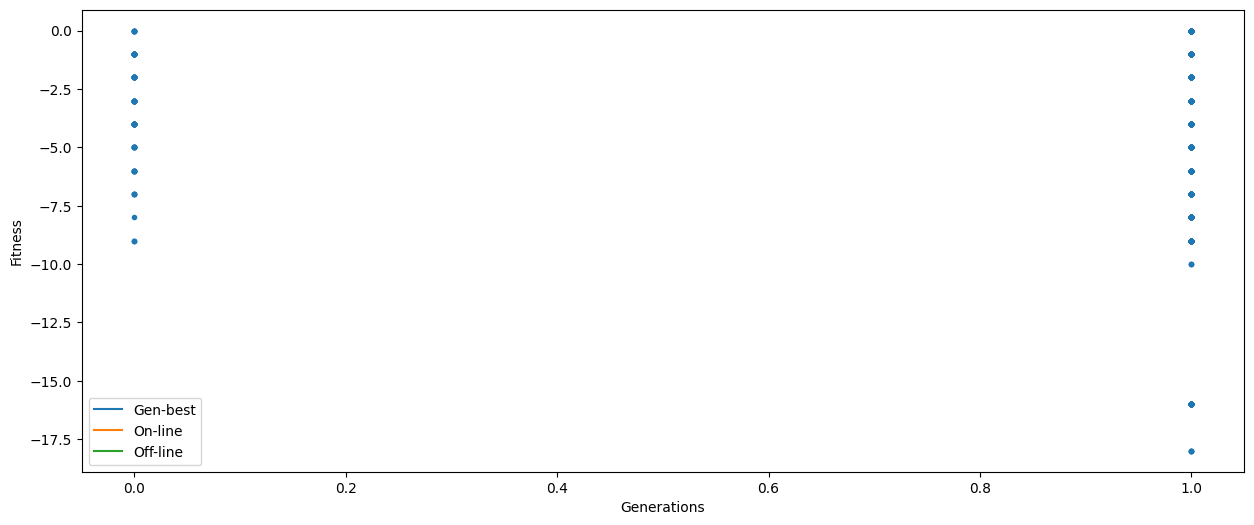

INFO:root:init: pop_size=100; max=(10, -36)
INFO:root:Best indivudual with fitness = (10, -12)
INFO:root:Number of generations: 50


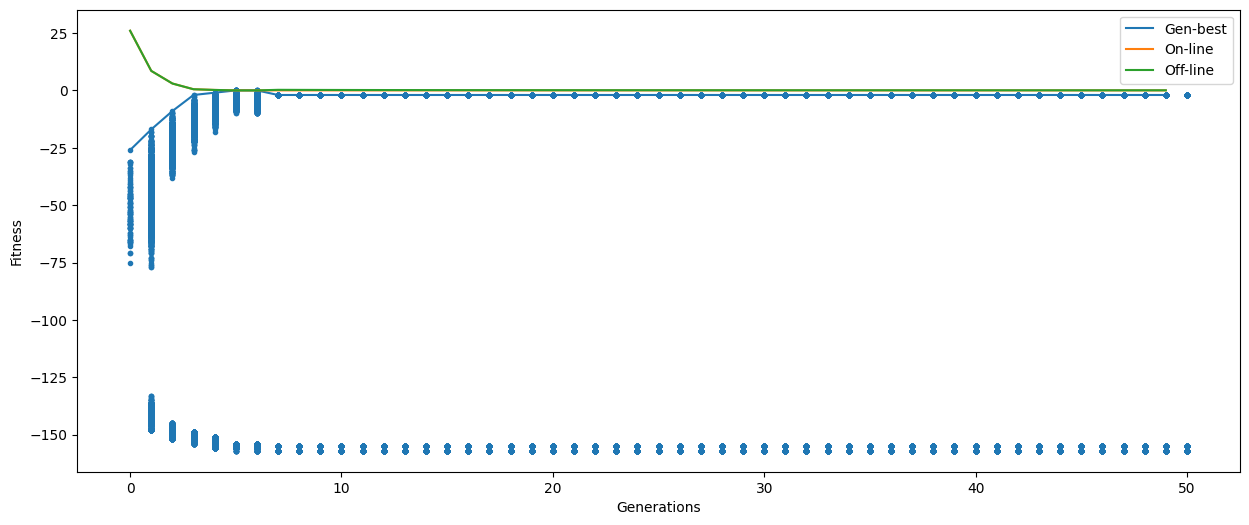

INFO:root:init: pop_size=100; max=(20, -53)
INFO:root:Best indivudual with fitness = (20, -26)
INFO:root:Number of generations: 50


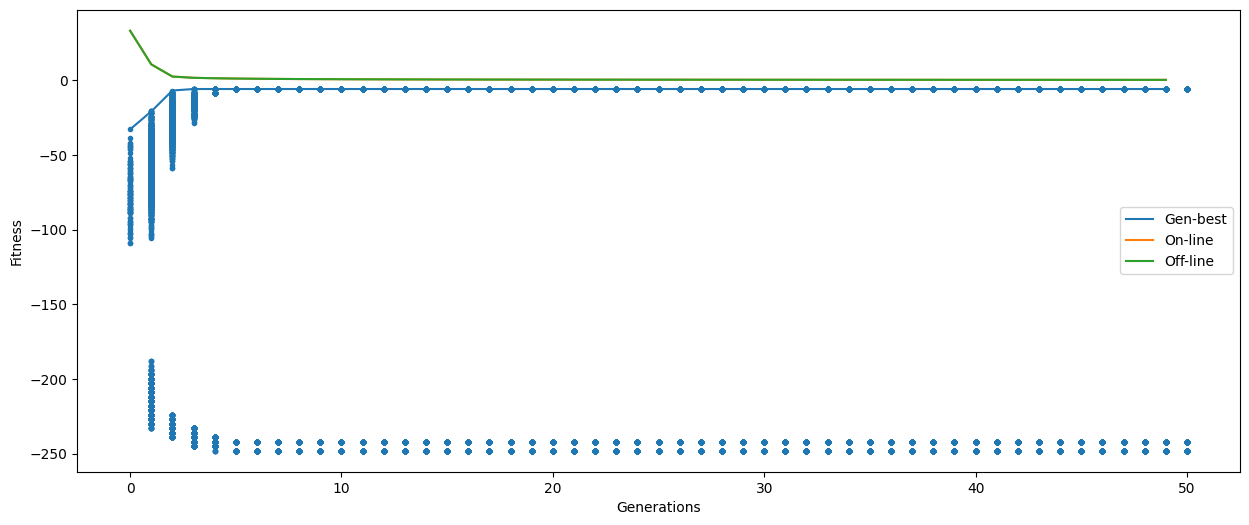

INFO:root:init: pop_size=100; max=(100, -5380)


KeyboardInterrupt: 

In [143]:
logging.getLogger().setLevel(logging.INFO)
for N in [5, 10, 20, 100]:#, 500, 1000]:
    fitness_log, actual_generations = evolution_steady_state(N)
    logging.info(f"Number of generations: {actual_generations}")
    evaluate_performance(fitness_log, actual_generations)